In [29]:
import sys
import os
directory = os.path.abspath(os.path.join('..'))
sys.path.append(directory)
import numpy as np
from matplotlib import pyplot as plt
from scripts.model_params import *
from scripts.cell_model_batch_culture import *
from scripts.batch_culture_simulation import *
import os
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination

Defining and importing base parameters

In [2]:
# defining parameters
sS0 = 0.5; cultvol = 1.25 #quality of the nutrients and volume of the culture
vX = 726; kX = 1e3 # X export parameters
tmax = 1000; runintmax = 1e6 #simulation time parameters

N0  = 1e6
xS0 = ((10*cultvol)/180)*6.02e23; # amount of glucose in media = 10g/L in 1.25L working vol in 3L vessel
M0 = 1e8 

Defining the system topology parameters

In [3]:
#choosing the product transport method. 1 indicates this method is included
lin_trans      = 1
Tp_trans       = 0
T_trans        = 0
diff_trans     = 0

#mutaually exclusive; only one of these can be 1, rest must be 0
eprodtox       = 1
elongationtox  = 0

topology = [lin_trans, Tp_trans, T_trans, diff_trans, eprodtox, elongationtox]

creating the host and engineered parameter arrays

In [4]:
base_params = [xS0, runintmax, tmax, N0, topology]

hPR0, xPR0 = model_params(sS0, vX, kX, cultvol, leaky_control=False)
hPR = np.array(hPR0)
xPR = np.array(xPR0)
# 0     1       2       3       4         5        6        7           8
#[w0,   wE,     wEp,    wTF,    wpTox,    wTp,     k_Ep,    Km_Ep,      k_Tp,
#   9      10             11                 12
# # Km_Tp, a_energy_pTox, a_elongation_pTox, K_E, 
#   13      14      15       16       17   18
# # K_pTox, kdiffP, VolCell, VolCult, ksf, ksr]

Setting specific circuit parameters

In [5]:
wE = 20; wEp = 20; wTF = 20; wpTox = 2;
K_E = 0.3; K_pTox = 1.0

xPR[[1, 2, 3, 4, 12, 13]] = [wE, wEp, wTF, wpTox, K_E, K_pTox]

Writing a wrapper to take wEp and return the productivity and yield

In [6]:
xPR_temp = xPR.copy()
def prod_yield_wEp(wEp_temp):
    xPR_temp[2] = wEp_temp
    vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_temp)
    return -vP, -pY

def obj_vector(X):
    xPR_temp = xPR.copy()
    xPR_temp[2] = X[0]
    vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_temp)
    return -vP, -pY     

Running the single objective optimisations

In [7]:
wEp_range = np.linspace(0, 100, 100)
vPs = []; pYs = []
for wEp_temp in wEp_range:
    vP_temp, pY_temp = prod_yield_wEp(wEp_temp)
    vPs.append(vP_temp); pYs.append(pY_temp)
vPs = np.array(vPs); pYs = np.array(pYs)


Setting up the optimisation problems

In [ ]:
x_lower, x_upper = 0, 100


class MaxVProdProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=1, n_obj=1, xl=[x_lower], xu=[x_upper])

    def _evaluate(self, x, out, *args, **kwargs):

        xPR_local = xPR.copy()            # <-- FIX
        xPR_local[2] = float(x[0])

        vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_local)
        out["F"] = [-vP]


class MaxYieldProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=1, n_obj=1, xl=[x_lower], xu=[x_upper])

    def _evaluate(self, x, out, *args, **kwargs):

        xPR_local = xPR.copy()            # <-- FIX
        xPR_local[2] = float(x[0])

        vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_local)
        out["F"] = [-pY]

Running the optimisation to find optimal vP

In [34]:
res1 = minimize(MaxVProdProblem(), GA(pop_size=30), seed=1, verbose=True)
max_vP = abs(res1.F[0])   
print("Max vP:", max_vP)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 | -2.423126E+06 | -2.680425E+06
     2 |       60 | -2.657922E+06 | -2.680440E+06
     3 |       90 | -2.678958E+06 | -2.680485E+06
     4 |      120 | -2.680240E+06 | -2.680485E+06
     5 |      150 | -2.680416E+06 | -2.680485E+06
     6 |      180 | -2.680440E+06 | -2.680486E+06
     7 |      210 | -2.680460E+06 | -2.680486E+06
     8 |      240 | -2.680481E+06 | -2.680488E+06
     9 |      270 | -2.680484E+06 | -2.680488E+06
    10 |      300 | -2.680485E+06 | -2.680488E+06
    11 |      330 | -2.680486E+06 | -2.680488E+06
    12 |      360 | -2.680487E+06 | -2.680488E+06
    13 |      390 | -2.680487E+06 | -2.680488E+06
    14 |      420 | -2.680487E+06 | -2.680488E+06
    15 |      450 | -2.680488E+06 | -2.680488E+06
    16 |      480 | -2.680488E+06 | -2.680488E+06
    17 |      510 | -2.680488E+06 | -2.680488E+06
    18 |      540 | -2.680488E+06 | -2.680488E+06
    19 |      570 | -2.680488E+06 | -2.680488E+06


Running the optimisation to find optimisal pY

In [35]:
res2 = minimize(MaxYieldProblem(), GA(pop_size=30), seed=1, verbose=True)
max_pY = abs(res2.F[0])     
print("Max pY:", max_pY)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 | -5.793267E-14 | -6.411647E-14
     2 |       60 | -6.357821E-14 | -6.411685E-14
     3 |       90 | -6.408139E-14 | -6.411790E-14
     4 |      120 | -6.411206E-14 | -6.411790E-14
     5 |      150 | -6.411626E-14 | -6.411790E-14
     6 |      180 | -6.411685E-14 | -6.411793E-14
     7 |      210 | -6.411732E-14 | -6.411794E-14
     8 |      240 | -6.411781E-14 | -6.411798E-14
     9 |      270 | -6.411789E-14 | -6.411798E-14
    10 |      300 | -6.411792E-14 | -6.411798E-14
    11 |      330 | -6.411795E-14 | -6.411799E-14
    12 |      360 | -6.411796E-14 | -6.411799E-14
    13 |      390 | -6.411796E-14 | -6.411799E-14
    14 |      420 | -6.411797E-14 | -6.411799E-14
    15 |      450 | -6.411798E-14 | -6.411799E-14
    16 |      480 | -6.411798E-14 | -6.411799E-14
    17 |      510 | -6.411798E-14 | -6.411799E-14
    18 |      540 | -6.411798E-14 | -6.411799E-14
    19 |      570 | -6.411798E-14 | -6.411799E-14


Setting up the multiobjective optimisation problem

In [ ]:
scale = np.array([max_vP, max_pY])
class MultiObjScaled(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=1, n_obj=2, xl=[x_lower], xu=[x_upper])

    def _evaluate(self, x, out, *args, **kwargs):

        xPR_local = xPR.copy()            # <-- FIX
        xPR_local[2] = float(x[0])

        vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_local)

        obj = np.array([-vP, -pY]) / scale
        out["F"] = obj

Running the optimisation

In [37]:
termination = get_termination("n_gen", 80)

res = minimize(MultiObjScaled(),
               NSGA2(pop_size=60),
               termination,
               seed=1,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       60 |      1 |             - |             -
     2 |      120 |      1 |  0.0000171430 |             f
     3 |      180 |      1 |  0.0000171430 |             f
     4 |      240 |      1 |  0.0000171430 |             f
     5 |      300 |      1 |  0.0000172247 |             f
     6 |      360 |      1 |  0.0000172247 |             f
     7 |      420 |      1 |  0.0000172796 |             f
     8 |      480 |      1 |  0.0000173393 |             f
     9 |      540 |      1 |  0.0000173393 |             f
    10 |      600 |      1 |  0.0000173393 |             f
    11 |      660 |      1 |  0.0000174857 |             f
    12 |      720 |      1 |  0.0000174896 |             f
    13 |      780 |      1 |  0.0000177197 |             f
    14 |      840 |      1 |  0.0000177197 |             f
    15 |      900 |      1 |  0.0000177197 |             f
    16 |      960 |      1 |  0.0000178401 |            

Extracting the pareto front

In [38]:
pareto_X = res.X
pareto_scaled = res.F
pareto_unscaled = pareto_scaled * scale   

vP_vals = -pareto_unscaled[:, 0]
pY_vals = -pareto_unscaled[:, 1]

Now plotting the pareto front

In [43]:
for x in [0, 10, 20, 30, 40]:
    xPR_local = xPR.copy()
    xPR_local[2] = x
    vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_local)
    print(x, vP, pY)

0 1.1246805913453776e-19 2.6902658663411022e-39
10 1518704.6283899609 3.6327818353514014e-14
20 2184900.011315987 5.226338897500035e-14
30 2495241.267036947 5.968683429457149e-14
40 2632680.5689074807 6.297441892403276e-14


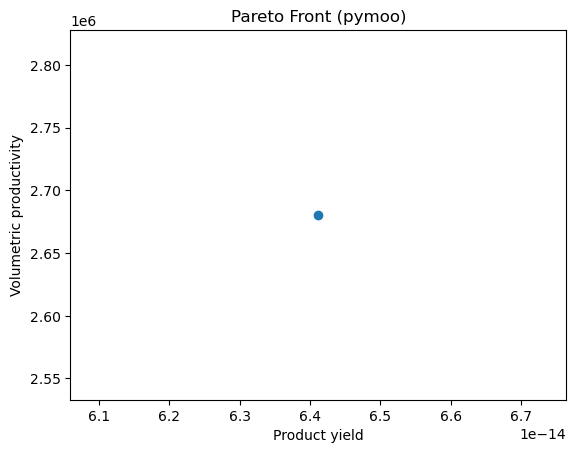

In [42]:
plt.scatter(pY_vals, vP_vals)
plt.xlabel("Product yield")
plt.ylabel("Volumetric productivity")
plt.title("Pareto Front (pymoo)")
plt.show()